---

# Classification Approach

By: Tomás Urdiales

-> Notebook for experiments attempting to turn into a classification problem.

##### Libraries

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error

from src import utils
from src.cross_validation import backtesting_CV
from src.join_qh_min_data import join_qh_min_data

##### Parameters

In [3]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [4]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]
temp = utils.load_temp_historical_data().loc["2021":"2022"]

# Additional features:
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()
# Add in XB data:
qh = qh.assign(xb_day_ahead = xb["xb_day_ahead"])
qh = qh.assign(xb_intraday = xb["xb_intraday"])
qh = qh.assign(xb_grand_total = xb["xb_grand_total"])
qh = qh.assign(xb_physical_accounting_net_import_mw = xb["xb_physical_accounting_net_import_mw"])
# Add in temperature data:
qh = qh.assign(temperature = temp["temperature"])
# Create temperature gradient with respect to one hour ahead:
qh = qh.assign(temperature_diff = -temp["temperature"].diff(-4))

---

## Prepare dataset

In [4]:
# Cut into three bins:
qh = qh.dropna(subset="system_imbalance_cum15")
qh.insert(0,
    "imbalance_class",
    pd.cut(qh["system_imbalance_cum15"], bins=[-2000, -200, 200, 2000], labels=[0, 1, 2])
    .astype(np.int8)
)

In [5]:
# Let's how many occurrences there are:
qh["imbalance_class"].value_counts(normalize=True)

imbalance_class
1    0.779624
0    0.139427
2    0.080949
Name: proportion, dtype: float64

---

## Prepare data matrix

In [6]:
MINUTE = 5

if MINUTE == "all":
    lag = 30
else:
    lag = 2

qh_parameters = {
    "imbalance_class": {
        "lags": [1, -1, -95, -671]
    },

    "xb_day_ahead": {
    "lags": [5, 1, 0, -4]},
    "xb_intraday": {
        "lags": [5, 1, 0, -4]},
    "xb_grand_total": {
        "lags": [5, 1, 0, -4]},
    "xb_physical_accounting_net_import_mw": {
        "lags": [-1, -2, -3, -4]},

    "system_imbalance_cum15": {
        "lags": [-1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "total_load_last_mw": {
        "lags": [-1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -2, -3, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "imbalance_class_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

Frequency identified as: qh


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES], df[TARGET].values, 
    test_size=0.25,
    shuffle=True,
    random_state=42,
)

---

## Naive Estimator

In [8]:
naive_pred = df[TARGET].shift(lag).loc[X_test.index]

# improvement = \
#     ((y_pred == y_test).sum() / (naive_pred == y_test).sum() - 1)*100

print(f"Naive estimator score: {(naive_pred == y_test).sum()/len(y_test):.4f}")
# print(f"Improvement: {improvement:.2f}%")

Naive estimator score: 0.7183


In [9]:
# Let's compare it for high SI scenarios:
# improvement = \
#     (((y_pred == y_test)[y_test != 0].sum() / \
#     (naive_pred == y_test)[y_test != 0].sum()) - 1)*100

print(f"Naive estimator score on high SI: \
{(naive_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]):.4f}")
# print(f"Improvement: {improvement:.2f}%")

Naive estimator score on high SI: 0.3506


---

## Modelling

In [10]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(
    hidden_layer_sizes=[25, 25],
    alpha=0.5,
    tol=1e-3,
    shuffle=True,
    activation="relu",
    validation_fraction=0.1,
    solver="lbfgs",
    max_iter=750,
    # batch_size=10,
    early_stopping=True,
    n_iter_no_change=10,
    momentum=True,
    verbose=5,
)

model_mlp = make_pipeline(StandardScaler(), model_mlp)

model_mlp.fit(X_train, y_train)
y_pred_train = model_mlp.predict(X_train)
y_pred = model_mlp.predict(X_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2278     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90273D-01    |proj g|=  3.03763D-01

At iterate    1    f=  8.11369D-01    |proj g|=  9.75591D-02


 This problem is unconstrained.



At iterate    2    f=  7.61349D-01    |proj g|=  7.89024D-02

At iterate    3    f=  6.38012D-01    |proj g|=  8.28639D-02

At iterate    4    f=  6.00395D-01    |proj g|=  3.79807D-02

At iterate    5    f=  5.78855D-01    |proj g|=  2.17848D-02

At iterate    6    f=  5.65914D-01    |proj g|=  4.13309D-02

At iterate    7    f=  5.60290D-01    |proj g|=  1.13061D-02

At iterate    8    f=  5.55560D-01    |proj g|=  1.56272D-02

At iterate    9    f=  5.45974D-01    |proj g|=  8.89924D-03

At iterate   10    f=  5.41751D-01    |proj g|=  3.71737D-02

At iterate   11    f=  5.37577D-01    |proj g|=  8.58048D-03

At iterate   12    f=  5.35754D-01    |proj g|=  9.26606D-03

At iterate   13    f=  5.32384D-01    |proj g|=  1.44008D-02

At iterate   14    f=  5.26787D-01    |proj g|=  6.15706D-03

At iterate   15    f=  5.23231D-01    |proj g|=  2.27525D-02

At iterate   16    f=  5.21596D-01    |proj g|=  7.15649D-03

At iterate   17    f=  5.20542D-01    |proj g|=  7.57517D-03

At iter

In [11]:
print(f"Train set score: {(y_pred_train == y_train).sum() / len(y_train):.4f}")
print(f"Test set score: {(y_pred == y_test).sum() / len(y_test):.4f}\n")

print(f"Train set score on high SI: \
{(y_pred_train == y_train)[y_train != 1].sum() / len(y_train[y_train != 1]) :.4f}")
print(f"Test set score on high SI: \
{(y_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]) :.4f}")

Train set score: 0.8254
Test set score: 0.8024

Train set score on high SI: 0.3682
Test set score on high SI: 0.3169


In [ ]:
from sklearn.svm import SVC

model_svc = SVC(
    kernel="rbf",
    gamma="scale",
    C=20,
    tol=1e-3,
    cache_size=1000,
    verbose=True,
)

model_svc = make_pipeline(StandardScaler(), model_svc)

model_svc.fit(X_train, y_train)
y_pred_train = model_svc.predict(X_train)
y_pred = model_svc.predict(X_test)

[LibSVM]......................................................................................................................................................................................................................................................*......................................................................................................................................................................*.*
optimization finished, #iter = 413143
obj = -204967.859051, rho = 0.260155
nSV = 17631, nBSV = 8432
.............................*................*
optimization finished, #iter = 45352
obj = -28062.604142, rho = 0.038905
nSV = 3752, nBSV = 1116
....................................................................................................................................................................*..........................................................................................................*
optimization finished, #iter = 270568
obj = -113416.63301

In [ ]:
print(f"Train set score: {(y_pred_train == y_train).sum() / len(y_train):.4f}")
print(f"Test set score: {(y_pred == y_test).sum() / len(y_test):.4f}\n")

print(f"Train set score on high SI: \
{(y_pred_train == y_train)[y_train != 1].sum() / len(y_train[y_train != 1]) :.4f}")
print(f"Test set score on high SI: \
{(y_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]) :.4f}")

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest regressor model:
model_forest = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    criterion="log_loss",
    n_jobs=-1,
    verbose=True,
)

model_forest.fit(X_train, y_train)
y_pred_train = model_forest.predict(X_train)
y_pred = model_forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [45]:
print(f"Train set score: {(y_pred_train == y_train).sum() / len(y_train):.4f}")
print(f"Test set score: {(y_pred == y_test).sum() / len(y_test):.4f}\n")

print(f"Train set score on high SI: \
{(y_pred_train == y_train)[y_train != 1].sum() / len(y_train[y_train != 1]) :.4f}")
print(f"Test set score on high SI: \
{(y_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]) :.4f}")

Train set score: 0.7978
Test set score: 0.7929

Train set score on high SI: 0.1381
Test set score on high SI: 0.1332


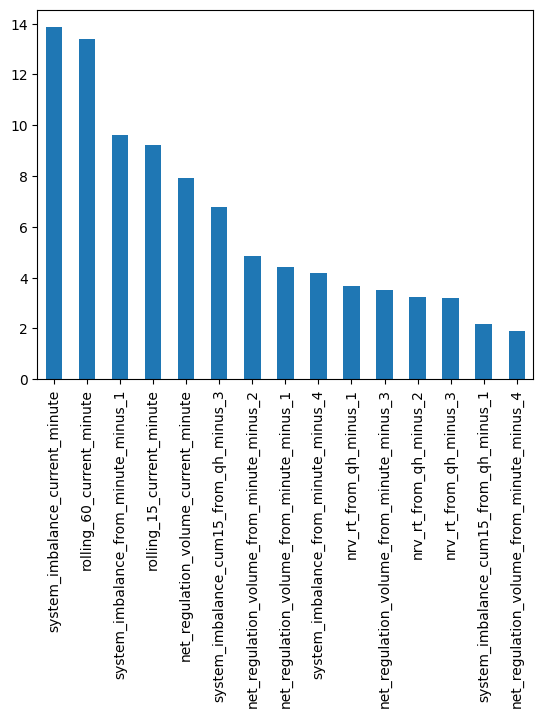

In [46]:
feature_importance = pd.DataFrame(data={"importance": 100*model_forest.feature_importances_}, index=FEATURES)

# Plot importance scores:
# fig, ax = plt.subplots(figsize=[15,5])
feature_importance.importance.nlargest(15).plot(kind="bar")
# ax.bar([ii for ii in range(len(FEATURES))], to_show)
# plt.xticks([ii for ii in range(len(FEATURES))], FEATURES)
plt.show()

In [48]:
from xgboost import XGBRFClassifier

# Start with a random forests attempt:
model_xgboost = XGBRFClassifier(
    max_depth=5,
    booster='gbtree',
    n_estimators=100,
    # objective='reg:squarederror',
    n_jobs=-1,
)

model_xgboost.fit(X_train, y_train)
y_pred_train = model_xgboost.predict(X_train)
y_pred = model_xgboost.predict(X_test)

In [49]:
print(f"Train set score: {(y_pred_train == y_train).sum() / len(y_train):.4f}")
print(f"Test set score: {(y_pred == y_test).sum() / len(y_test):.4f}\n")

print(f"Train set score on high SI: \
{(y_pred_train == y_train)[y_train != 1].sum() / len(y_train[y_train != 1]) :.4f}")
print(f"Test set score on high SI: \
{(y_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]) :.4f}")

Train set score: 0.8033
Test set score: 0.7959

Train set score on high SI: 0.1949
Test set score on high SI: 0.1809


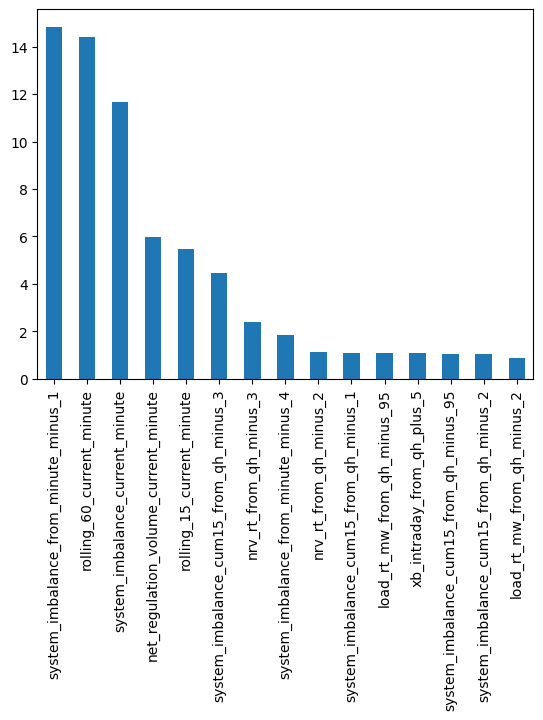

In [50]:
feature_importance = pd.DataFrame(data={"importance": 100*model_xgboost.feature_importances_}, index=FEATURES)

# Plot importance scores:
# fig, ax = plt.subplots(figsize=[15,5])
feature_importance.importance.nlargest(15).plot(kind="bar")
# ax.bar([ii for ii in range(len(FEATURES))], to_show)
# plt.xticks([ii for ii in range(len(FEATURES))], FEATURES)
plt.show()

---

## Validation

In [12]:
print(f"\nTrain set score: {(y_pred_train == y_train).sum() / len(y_train):.4f}")
print(f"Test set score: {(y_pred == y_test).sum() / len(y_test):.4f}\n")

print(f"Train set score on high SI: \
{(y_pred_train == y_train)[y_train != 1].sum() / len(y_train[y_train != 1]) :.4f}")
print(f"Test set score on high SI: \
{(y_pred == y_test)[y_test != 1].sum() / len(y_test[y_test != 1]) :.4f}")


Train set score: 0.8254
Test set score: 0.8024

Train set score on high SI: 0.3682
Test set score on high SI: 0.3169


In [21]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average="weighted")

0.77747272977545

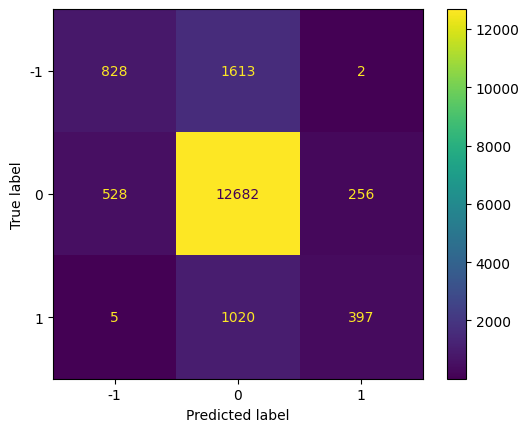

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=[-1, 0, 1]
    ).plot()
plt.show()

# plt.gcf().savefig("confusion.png", dpi=300);

---

## Testing Regression

In [5]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "xb_day_ahead": {
        "lags": [5, 1, 0, -4]},
    "xb_intraday": {
        "lags": [5, 1, 0, -4]},
    "xb_grand_total": {
        "lags": [5, 1, 0, -4]},
    "xb_physical_accounting_net_import_mw": {
        "lags": [-1, -2, -3, -4]},

    "total_load_last_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [6]:
# Split up using only 2022 !!
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES].loc["2022"], df[TARGET].loc["2022"].values, 
    test_size=0.3,
    shuffle=True,
    random_state=42,
)

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_linear = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
# model_linear = make_pipeline(RobustScaler(), LinearRegression(n_jobs=-1))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 102.60MW | RMSE: 135.71MW
Test set average error:
MAE: 102.73MW | RMSE: 136.02MW


In [8]:
model_linear = make_pipeline(StandardScaler(), Ridge(alpha=1.0, tol=1e-4, max_iter=1000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 102.60MW | RMSE: 135.71MW
Test set average error:
MAE: 102.73MW | RMSE: 136.02MW


In [9]:
model_linear = make_pipeline(StandardScaler(), Lasso(alpha=1.0, tol=1e-4, max_iter=2000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 104.12MW | RMSE: 137.76MW
Test set average error:
MAE: 104.14MW | RMSE: 137.97MW


In [10]:
selected_features_Lasso = df[FEATURES].columns[np.abs(model_linear[1].coef_) > 0]

table_coefs = pd.DataFrame(data={"coef": model_linear[1].coef_}, index=df[FEATURES].columns)
table_coefs["coef_abs"] = table_coefs["coef"].abs()

table_coefs.loc[selected_features_Lasso].sort_values(by="coef_abs", ascending=False)[["coef"]]

,coef
xb_grand_total_current_qh,168.648180
xb_grand_total_from_qh_plus_1,-162.598830
system_imbalance_current_minute,78.031700
system_imbalance_cum15_from_qh_minus_3,47.711681
system_imbalance_cum15_from_qh_minus_95,29.410699
system_imbalance_cum15_from_qh_minus_671,26.427907
system_imbalance_cum15_from_qh_minus_96,-17.545808
total_load_last_mw_from_qh_plus_3,-13.866916
nrv_rt_from_qh_minus_671,12.582653
nrv_rt_from_qh_minus_1,-11.713938


In [83]:
from sklearn.neural_network import MLPRegressor

model_mlp = MLPRegressor(
    hidden_layer_sizes=[30, 30, 30],
    alpha=0.5,
    tol=1e-3,
    shuffle=True,
    activation="relu",
    validation_fraction=0.1,
    solver="lbfgs",
    # learning_rate_init= 0.01,
    max_iter=500,
    # batch_size=10,
    early_stopping=True,
    n_iter_no_change=5,
    momentum=True,
    verbose=5,
)

model_mlp = make_pipeline(StandardScaler(), model_mlp)

model_mlp.fit(X_train, y_train)
y_pred_train = model_mlp.predict(X_train)
y_pred = model_mlp.predict(X_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3121     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75780D+04    |proj g|=  2.70212D+01


 This problem is unconstrained.



At iterate    1    f=  1.44655D+04    |proj g|=  5.22964D+02

At iterate    2    f=  1.44202D+04    |proj g|=  5.69747D+02

At iterate    3    f=  1.37810D+04    |proj g|=  3.59195D+02

At iterate    4    f=  1.35593D+04    |proj g|=  1.59257D+02

At iterate    5    f=  1.34572D+04    |proj g|=  1.45307D+02

At iterate    6    f=  1.32769D+04    |proj g|=  2.01192D+02

At iterate    7    f=  1.31308D+04    |proj g|=  1.07314D+02

At iterate    8    f=  1.29848D+04    |proj g|=  1.41809D+02

At iterate    9    f=  1.21728D+04    |proj g|=  2.54838D+02

At iterate   10    f=  1.12043D+04    |proj g|=  1.24959D+02

At iterate   11    f=  1.09978D+04    |proj g|=  2.10427D+02

At iterate   12    f=  1.07578D+04    |proj g|=  8.57368D+01

At iterate   13    f=  1.06806D+04    |proj g|=  5.86238D+01

At iterate   14    f=  1.06219D+04    |proj g|=  1.01718D+02

At iterate   15    f=  1.05161D+04    |proj g|=  6.76521D+01

At iterate   16    f=  1.04667D+04    |proj g|=  1.45521D+02

At iter

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [84]:
total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print(f"Total train-set MAE: {total_mae:.2f}MW | Total train-set RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print(f"Total test-set MAE: {total_mae:.2f}MW | Total test-set RMSE: {total_rmse:.2f}MW")

Total train-set MAE: 98.46MW | Total train-set RMSE: 129.61MW
Total test-set MAE: 99.66MW | Total test-set RMSE: 131.40MW


#### To select AR qh features

In [40]:
MINUTE = "all"

lags = [-x for x in range(-1, 50)]
lags.remove(0)
lags.extend([1-4*24, 1-4*24+1, 1-4*24-1, 1-4*24*7, 1-4*24*7+1, 1-4*24*7-1])

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": lags},
}

lags = [-x for x in range(0, 65)]
lags.remove(0)
lags.extend([-60*2, -60*2+1, -60*2-1, -60*3, -60*3+1, -60*3-1, -60*24, -60*24+1, -60*24-1])

minute_parameters = {
    "system_imbalance": {
        "lags": lags},
    "rolling_15": {
        "lags": [-2]},
    "rolling_60": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    # minute_data=minute,
    qh_parameters=qh_parameters,
    # minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [66]:
df.shape

(1031895, 56)

In [42]:
# Split up using only 2022 !!
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES].loc["2022"], df[TARGET].loc["2022"].values, 
    test_size=0.3,
    shuffle=True,
    random_state=42,
)

In [43]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_linear = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 114.84MW | RMSE: 153.39MW
Test set average error:
MAE: 114.93MW | RMSE: 153.64MW


In [44]:
model_linear = make_pipeline(StandardScaler(), Ridge(alpha=0.5, tol=1e-4, max_iter=1000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 114.84MW | RMSE: 153.39MW
Test set average error:
MAE: 114.93MW | RMSE: 153.64MW


In [67]:
model_linear = make_pipeline(StandardScaler(), Lasso(alpha=3.0, tol=1e-4, max_iter=2000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 115.63MW | RMSE: 154.46MW
Test set average error:
MAE: 115.71MW | RMSE: 154.68MW


In [68]:
selected_features_Lasso = df[FEATURES].columns[np.abs(model_linear[1].coef_) > 0]

table_coefs = pd.DataFrame(data={"coef": model_linear[1].coef_}, index=df[FEATURES].columns)
table_coefs["coef_abs"] = table_coefs["coef"].abs()

table_coefs.loc[selected_features_Lasso].sort_values(by="coef_abs", ascending=False)[["coef"]]

,coef
system_imbalance_cum15_from_qh_minus_1,58.552006
system_imbalance_cum15_from_qh_minus_3,51.098980
system_imbalance_cum15_from_qh_minus_95,19.029850
system_imbalance_cum15_from_qh_minus_671,13.098340
system_imbalance_cum15_from_qh_minus_5,-9.248647
system_imbalance_cum15_from_qh_minus_21,4.822354
system_imbalance_cum15_from_qh_minus_17,4.001743
system_imbalance_cum15_from_qh_minus_23,-3.895774
system_imbalance_cum15_from_qh_minus_13,3.787340
system_imbalance_cum15_from_qh_minus_25,3.372948


#### To select AR min features

In [81]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
}

lags = [-x for x in range(0, 65)]
lags.remove(0); lags.remove(-1), lags.remove(-2)
lags.extend([-60*2, -60*2+1, -60*2-1, -60*3, -60*3+1, -60*3-1, -60*24, -60*24+1, -60*24-1])

minute_parameters = {
    "system_imbalance": {
        "lags": lags},
    "rolling_15": {
        "lags": [-2]},
    "rolling_60": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [83]:
# Split up using only 2022 !!
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES].loc["2022"], df[TARGET].loc["2022"].values, 
    test_size=0.3,
    shuffle=True,
    random_state=42,
)

In [84]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_linear = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 113.31MW | RMSE: 150.22MW
Test set average error:
MAE: 113.42MW | RMSE: 150.65MW


In [85]:
model_linear = make_pipeline(StandardScaler(), Ridge(alpha=0.5, tol=1e-4, max_iter=1000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 113.31MW | RMSE: 150.22MW
Test set average error:
MAE: 113.42MW | RMSE: 150.66MW


In [88]:
model_linear = make_pipeline(StandardScaler(), Lasso(alpha=5.0, tol=1e-4, max_iter=2000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 114.50MW | RMSE: 152.15MW
Test set average error:
MAE: 114.68MW | RMSE: 152.60MW


In [87]:
selected_features_Lasso = df[FEATURES].columns[np.abs(model_linear[1].coef_) > 0]

table_coefs = pd.DataFrame(data={"coef": model_linear[1].coef_}, index=df[FEATURES].columns)
table_coefs["coef_abs"] = table_coefs["coef"].abs()

table_coefs.loc[selected_features_Lasso].sort_values(by="coef_abs", ascending=False)[["coef"]]

,coef
system_imbalance_from_minute_minus_3,68.457920
system_imbalance_from_minute_minus_45,22.987512
rolling_60_from_minute_minus_2,7.197119
system_imbalance_from_minute_minus_181,5.338349
system_imbalance_from_minute_minus_18,4.249696
system_imbalance_from_minute_minus_33,4.171103
system_imbalance_from_minute_minus_64,-3.061585
system_imbalance_from_minute_minus_44,2.862208
system_imbalance_from_minute_minus_43,2.827522
system_imbalance_from_minute_minus_63,-2.065692


#### To select AR

In [21]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, -6, -7, -8, -9, -95, -94, -96, -671, -670, -672, -17, -21, -23,
        -95*2, -94*2, -93*2, -96*2]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -45, -181, -18, -33, -64, -44, -43, -63]},
    "rolling_15": {
        "lags": [-2]},
    "rolling_60": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [22]:
# Split up using only 2022 !!
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES].loc["2022"], df[TARGET].loc["2022"].values, 
    test_size=0.3,
    shuffle=True,
    random_state=42,
)

In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model_linear = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
model_linear = make_pipeline(StandardScaler(), Ridge(alpha=0.5, tol=1e-4, max_iter=1000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 109.30MW | RMSE: 145.61MW
Test set average error:
MAE: 109.18MW | RMSE: 145.38MW


In [24]:
model_linear = make_pipeline(StandardScaler(), Lasso(alpha=1.0, tol=1e-4, max_iter=2000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 109.39MW | RMSE: 145.78MW
Test set average error:
MAE: 109.25MW | RMSE: 145.52MW


In [25]:
selected_features_Lasso = df[FEATURES].columns[np.abs(model_linear[1].coef_) > 0]

table_coefs = pd.DataFrame(data={"coef": model_linear[1].coef_}, index=df[FEATURES].columns)
table_coefs["coef_abs"] = table_coefs["coef"].abs()

table_coefs.loc[selected_features_Lasso].sort_values(by="coef_abs", ascending=False)[["coef"]]

,coef
system_imbalance_from_minute_minus_2,73.102816
system_imbalance_cum15_from_qh_minus_3,47.349847
system_imbalance_cum15_from_qh_minus_95,27.718452
system_imbalance_cum15_from_qh_minus_671,21.347004
system_imbalance_cum15_from_qh_minus_96,-13.776993
system_imbalance_cum15_from_qh_minus_672,-10.947722
system_imbalance_cum15_from_qh_minus_5,-7.476564
system_imbalance_cum15_from_qh_minus_21,7.124180
system_imbalance_cum15_from_qh_minus_1,6.711069
system_imbalance_from_minute_minus_63,-5.595873


In [20]:
# To remove from set:
df.columns[~df.columns.isin(selected_features_Lasso)]

Index(['system_imbalance_cum15_from_qh_plus_1',
       'system_imbalance_from_minute_minus_45',
       'system_imbalance_from_minute_minus_44',
       'system_imbalance_from_minute_minus_43',
       'rolling_15_from_minute_minus_2', 'rolling_60_from_minute_minus_2'],
      dtype='object')

#### To select all

In [5]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    # "wind_rt_mw": {
    #     "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}


minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64,-63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [6]:
# Split up using only 2022 !!
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURES].loc["2022"], df[TARGET].loc["2022"].values,
    test_size=0.3,
    shuffle=True,
    random_state=42,
)

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

# model_linear = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
model_linear = make_pipeline(StandardScaler(), Ridge(alpha=0.5, tol=1e-4, max_iter=1000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 103.40MW | RMSE: 136.87MW
Test set average error:
MAE: 102.70MW | RMSE: 136.07MW


In [48]:
model_linear = make_pipeline(StandardScaler(), Lasso(alpha=0.5, tol=1e-4, max_iter=2000))

model_linear.fit(X_train, y_train)
y_pred_train = model_linear.predict(X_train)
y_pred = model_linear.predict(X_test)

total_mae = mean_absolute_error(y_pred_train, y_train)
total_rmse = mean_squared_error(y_pred_train, y_train, squared=False)
print("Train set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

total_mae = mean_absolute_error(y_pred, y_test)
total_rmse = mean_squared_error(y_pred, y_test, squared=False)
print("Test set average error:")
print(f"MAE: {total_mae:.2f}MW | RMSE: {total_rmse:.2f}MW")

Train set average error:
MAE: 103.54MW | RMSE: 137.22MW
Test set average error:
MAE: 102.81MW | RMSE: 136.42MW


In [10]:
selected_features_Lasso = df[FEATURES].columns[np.abs(model_linear[1].coef_) > 0]

table_coefs = pd.DataFrame(data={"coef": model_linear[1].coef_}, index=df[FEATURES].columns)
table_coefs["coef_abs"] = table_coefs["coef"].abs()

table_coefs.loc[selected_features_Lasso].sort_values(by="coef_abs", ascending=False)[["coef"]].index[:25]

Index(['xb_grand_total_from_qh_plus_1', 'xb_grand_total_current_qh',
       'system_imbalance_from_minute_minus_2',
       'system_imbalance_cum15_from_qh_minus_3',
       'total_load_last_mw_from_qh_plus_3',
       'total_load_last_mw_from_qh_minus_3', 'xb_grand_total_from_qh_plus_4',
       'net_regulation_volume_from_minute_minus_2',
       'system_imbalance_cum15_from_qh_minus_95',
       'system_imbalance_cum15_from_qh_minus_191',
       'system_imbalance_cum15_from_qh_minus_671',
       'system_imbalance_cum15_from_qh_minus_287',
       'system_imbalance_cum15_from_qh_minus_383',
       'xb_grand_total_from_qh_minus_4',
       'system_imbalance_cum15_from_qh_minus_96',
       'system_imbalance_cum15_from_qh_minus_672', 'nrv_rt_from_qh_minus_1',
       'temperature_diff_from_qh_plus_4',
       'system_imbalance_cum15_from_qh_minus_192',
       'system_imbalance_cum15_from_qh_minus_384', 'nrv_rt_from_qh_minus_3',
       'system_imbalance_cum15_from_qh_minus_1',
       'system_imbal